In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as sklPp
import os
from sklearn.metrics import matthews_corrcoef,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier,SGDClassifier,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from statistics import NormalDist
from scipy import stats 
import random
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<p>The data set split the data into a training and test sets, considering we may want to allocate those ourselves later we will combine the two.</p>

In [2]:
#Get the data
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',header=None)
test  = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',skiprows=[0],sep=',', header=None)
#Append the data
data = data.append(test)
#Rename columns and print sample
data.rename(columns={0: "Age",1: "Workclass",2:"Final Weight",3:"Education",4:"Education_Num",5:"Marital-status",6:"Occupation",7:"Relationship",8:"Race",9:"Sex",10:"Capital-gain",11:"Capital-loss",12:"Hours/week",13:"Native_Country",14:"Result"},inplace = "True")
print(data.head(5))


   Age          Workclass  Final Weight   Education  Education_Num  \
0   39          State-gov         77516   Bachelors             13   
1   50   Self-emp-not-inc         83311   Bachelors             13   
2   38            Private        215646     HS-grad              9   
3   53            Private        234721        11th              7   
4   28            Private        338409   Bachelors             13   

        Marital-status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital-gain  Capital-loss  Hours/week  Native_Country  Result  
0          2174             0       

In [3]:
def cleanData(data):
    #Drop these columns as the data is mainly irrelevant.
    data.drop(['Capital-gain','Capital-loss',"Final Weight","Education"],axis =1,inplace = True)
    #Remove all rows where data is missing.
    for column in data.columns:
        #In the object columns, ? is used as NaN so remove them
        if data[column].dtypes == "object":
            data.drop(data[(data[column] == " ?")].index,inplace = True)
        #Remove any NaN values
        data = data[data[column].notnull()]
    #Replace str so theyre equal
    data['Result'] = data['Result'].str.replace(">50K.",">50K")
    data['Result'] = data['Result'].str.replace("<=50K.","<=50K")
    #Reset index 
    data.reset_index(drop=True, inplace=True)
    return data

In [4]:
def createCombined(data):
    #To allow for analysis of multiple sensitive attributes, create a shared column
    data['Sex_Race'] = data['Sex']+data['Race']
    #Remove the old columns
    data.drop(['Sex','Race'],axis = 1,inplace = True)
    return data

In [5]:
#Clean the data and print a sample
cleaned = cleanData(data)
print("Cleaned \n",cleaned.head(5))
print("\n")
#Create the combined column "Sex_Race"
combined = createCombined(cleaned)
print("Combined \n",combined.head(5))


Cleaned 
    Age          Workclass  Education_Num       Marital-status  \
0   39          State-gov             13        Never-married   
1   50   Self-emp-not-inc             13   Married-civ-spouse   
2   38            Private              9             Divorced   
3   53            Private              7   Married-civ-spouse   
4   37            Private             14   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Hours/week  \
0        Adm-clerical   Not-in-family   White     Male          40   
1     Exec-managerial         Husband   White     Male          13   
2   Handlers-cleaners   Not-in-family   White     Male          40   
3   Handlers-cleaners         Husband   Black     Male          40   
4     Exec-managerial            Wife   White   Female          40   

   Native_Country  Result  
0   United-States   <=50K  
1   United-States   <=50K  
2   United-States   <=50K  
3   United-States   <=50K  
4   United-States   <=50K  


Combined

In [6]:
def analyseData(data):
    for sexRace in data['Sex_Race'].unique():
        demographicData = data.loc[data['Sex_Race'] == sexRace]
        #Print the averages of each column
        print(sexRace)
        print("Size:",len(demographicData.index))
        print("Avg Age:", demographicData["Age"].mean())
        print("Mode Workclass:", demographicData["Workclass"].mode())
        print("Mode Education Num:", demographicData["Education_Num"].mode())
        print("Mode Marital Status:", demographicData["Marital-status"].mode())
        print("Mode Occupation:", demographicData["Occupation"].mode())
        print("Mode Relationship Status:", demographicData["Relationship"].mode())
        print("Avg Hours/week:", demographicData["Hours/week"].mean())
        print("Mode Native Country:", demographicData["Native_Country"].mode())
        print("Mode Result:", demographicData["Result"].mode())
        print("\n")

In [7]:
analyseData(combined)

 Male White
Size: 25667
Avg Age: 39.45720185452137
Mode Workclass: 0     Private
dtype: object
Mode Education Num: 0    9
dtype: int64
Mode Marital Status: 0     Married-civ-spouse
dtype: object
Mode Occupation: 0     Craft-repair
dtype: object
Mode Relationship Status: 0     Husband
dtype: object
Avg Hours/week: 43.12428410020649
Mode Native Country: 0     United-States
dtype: object
Mode Result: 0     <=50K
dtype: object


 Male Black
Size: 2050
Avg Age: 37.91268292682927
Mode Workclass: 0     Private
dtype: object
Mode Education Num: 0    9
dtype: int64
Mode Marital Status: 0     Married-civ-spouse
dtype: object
Mode Occupation: 0     Other-service
dtype: object
Mode Relationship Status: 0     Husband
dtype: object
Avg Hours/week: 40.3419512195122
Mode Native Country: 0     United-States
dtype: object
Mode Result: 0     <=50K
dtype: object


 Female White
Size: 11256
Avg Age: 36.84061833688699
Mode Workclass: 0     Private
dtype: object
Mode Education Num: 0    9
dtype: int64
Mode M

In [8]:
def encode(data):
    for column in data.columns:
        if data[column].dtypes == "object":
        #Create a label encoder
            lE = sklPp.LabelEncoder()
            data[column] = lE.fit_transform(data[column])
            #Print the mapping
            mapping = dict(zip(lE.classes_, lE.transform(lE.classes_)))
            print(column,mapping)
    return data

In [9]:
#Encode any categorical data
encoded = encode(combined)
#Get the value of different types of sex_race
sexRaceVariety = encoded['Sex_Race'].value_counts()
print("Variety of Sex/Race \n",sexRaceVariety)

Workclass {' Federal-gov': 0, ' Local-gov': 1, ' Private': 2, ' Self-emp-inc': 3, ' Self-emp-not-inc': 4, ' State-gov': 5, ' Without-pay': 6}
Marital-status {' Divorced': 0, ' Married-AF-spouse': 1, ' Married-civ-spouse': 2, ' Married-spouse-absent': 3, ' Never-married': 4, ' Separated': 5, ' Widowed': 6}
Occupation {' Adm-clerical': 0, ' Armed-Forces': 1, ' Craft-repair': 2, ' Exec-managerial': 3, ' Farming-fishing': 4, ' Handlers-cleaners': 5, ' Machine-op-inspct': 6, ' Other-service': 7, ' Priv-house-serv': 8, ' Prof-specialty': 9, ' Protective-serv': 10, ' Sales': 11, ' Tech-support': 12, ' Transport-moving': 13}
Relationship {' Husband': 0, ' Not-in-family': 1, ' Other-relative': 2, ' Own-child': 3, ' Unmarried': 4, ' Wife': 5}
Native_Country {' Cambodia': 0, ' Canada': 1, ' China': 2, ' Columbia': 3, ' Cuba': 4, ' Dominican-Republic': 5, ' Ecuador': 6, ' El-Salvador': 7, ' England': 8, ' France': 9, ' Germany': 10, ' Greece': 11, ' Guatemala': 12, ' Haiti': 13, ' Holand-Netherlan

In [10]:
#Useful for debug
#fileSystem = os.path.join(os.getcwd(),"encoded.csv")
#encoded.to_csv(fileSystem, index = False, header=True)

In [11]:
def splitData(data):
    #Set x,y data
    y = data['Result']
    x = data.drop(['Result'],axis =1)
    #Split the data 70/30% train/test
    xTrain,xTest,yTrain,yTest = train_test_split(x, y, test_size=0.30)
    return xTrain,xTest,yTrain,yTest 

In [12]:
def biasModel(xTrain,xTest,yTrain,yTest,data):
    #Create model
    model = RandomForestClassifier().fit(xTrain, yTrain)
    #Commented out to improve speed, best features from this added to the model 
    #n_estimators = np.array([50,100,150,200,250])
    #max_features = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    #bootstrap = np.array([True,False])
    #parameterGrid = dict(n_estimators=n_estimators,max_features=max_features,bootstrap = bootstrap)
    #grid = GridSearchCV(estimator=model, param_grid=parameterGrid, scoring=matthews_corrcoef)
    #results = grid.fit(xTrain, yTrain)
    #print(results.best_score_, results.best_params_)
    
    #Get the predictions and accuracy of them
    testPredictions = list(model.predict(xTest))
    accuracy = accuracy_score(testPredictions , yTest)

    combined = []
    rowList = data.values.tolist()
    #For each prediction, combine the test entry with the result
    for i in range(0,len(testPredictions)):
        combined.append(rowList[i] + [testPredictions[i]])
    return combined,model,accuracy

In [13]:
def evaluateFairness(results):
    #Defining privleged as white male/female
    #None-Priv as others
    priviliged = [4,9]
   
    privProb = 0
    privCount = 0
    nonPrivProb = 0
    nonPrivCount = 0
    #For each result, check if sex_race is privileged or not
    for result in results:
        if result[-2] in priviliged:
            privCount += 1
            if result[-1] == 1:
                privProb += 1
        else:
            nonPrivCount += 1
            if result[-1] == 1:
                nonPrivProb +=1
    #Get probabilities
    privProb = privProb/privCount
    nonPrivProb = nonPrivProb/nonPrivCount
    fairness = 1-(privProb-nonPrivProb)
    return fairness

In [14]:
def checkOverfit(xTrain,xTest,yTrain,yTest,model):
    #Check if the model overfits
    testPredictions = list(model.predict(xTest))
    testAccuracy = accuracy_score(testPredictions , yTest)
    trainPredictions = list(model.predict(xTrain))
    #Checks the accuracy of the model against the test and the training model
    trainAccuracy = accuracy_score(trainPredictions , yTrain)
    print("Test",testAccuracy, "Train",trainAccuracy)

In [15]:
def barChart(results):
    #Represents the encoding order
    encoding = [' Female Amer-Indian-Eskimo', ' Female Asian-Pac-Islander', ' Female Black', ' Female Other', ' Female White', ' Male Amer-Indian-Eskimo', ' Male Asian-Pac-Islander', ' Male Black', ' Male Other', ' Male White']
    scoresBySexRace = {}
    #For each sex_race
    for word in encoding:
        #Stores amount of 0s and 1s per sex_race
        scoresBySexRace[word] = [0,0]
    #For each result
    for result in results:
        #Get the sex_race of that result
        name = encoding[result[-2]]
        #Get the outcome and increment the respective one
        outcome = result[-1]
        scoresBySexRace[name][outcome] += 1
    
    plt.rcParams["figure.figsize"] = (40, 10)
    values = list(scoresBySexRace.values())
    #Replace any spaces and "-" with new lines to improve readability
    x = [name.replace(' ', '\n') for name in encoding]
    x = [name.replace('-', '\n') for name in x]
    graphValues = []
    maleAvg = 0
    femaleAvg = 0
    #For each value append it as a percentage 
    for value in values:
        graphValues.append((value[1]/(sum(value)))*100)

    x_pos = [i for i, _ in enumerate(x)]
    #Set matplotlib styling
    plt.bar(x_pos, graphValues, color='teal')
    # plotting a line plot after changing it's width and height
    plt.xlabel("Sex/Race",fontsize = 40)
    plt.ylabel("Acceptance Rate",fontsize = 40)
    plt.title("Acceptance Rate by Sex/Race",fontsize = 40)
   
    plt.xticks(x_pos, x,fontsize=40)
    plt.yticks(fontsize = 30)
    plt.show()

Test 0.8159528243327127 Train 0.9653830806065443
Accuracy 0.8159528243327127
Fairness 0.9958981131320407


Test 0.8149441340782123 Train 0.9653830806065443
Accuracy 0.8149441340782123
Fairness 0.9947130225358211


Test 0.8178926132836747 Train 0.9653498270816706
Accuracy 0.8178926132836747
Fairness 0.9983983541520008


Test 0.8159528243327127 Train 0.9653498270816706
Accuracy 0.8159528243327127
Fairness 0.9981427820433764


Test 0.8154872749844817 Train 0.9653830806065443
Accuracy 0.8154872749844817
Fairness 0.9941936927350218


Test 0.8155648665425201 Train 0.965316573556797
Accuracy 0.8155648665425201
Fairness 0.9913878565958523


Test 0.8153320918684047 Train 0.965316573556797
Accuracy 0.8153320918684047
Fairness 0.9937498522047414


Test 0.8157976412166357 Train 0.9653498270816706
Accuracy 0.8157976412166357
Fairness 0.9950104320714801


Test 0.8151769087523277 Train 0.9653498270816706
Accuracy 0.8151769087523277
Fairness 0.9937644043532752


Test 0.8150993171942893 Train 0.9653830

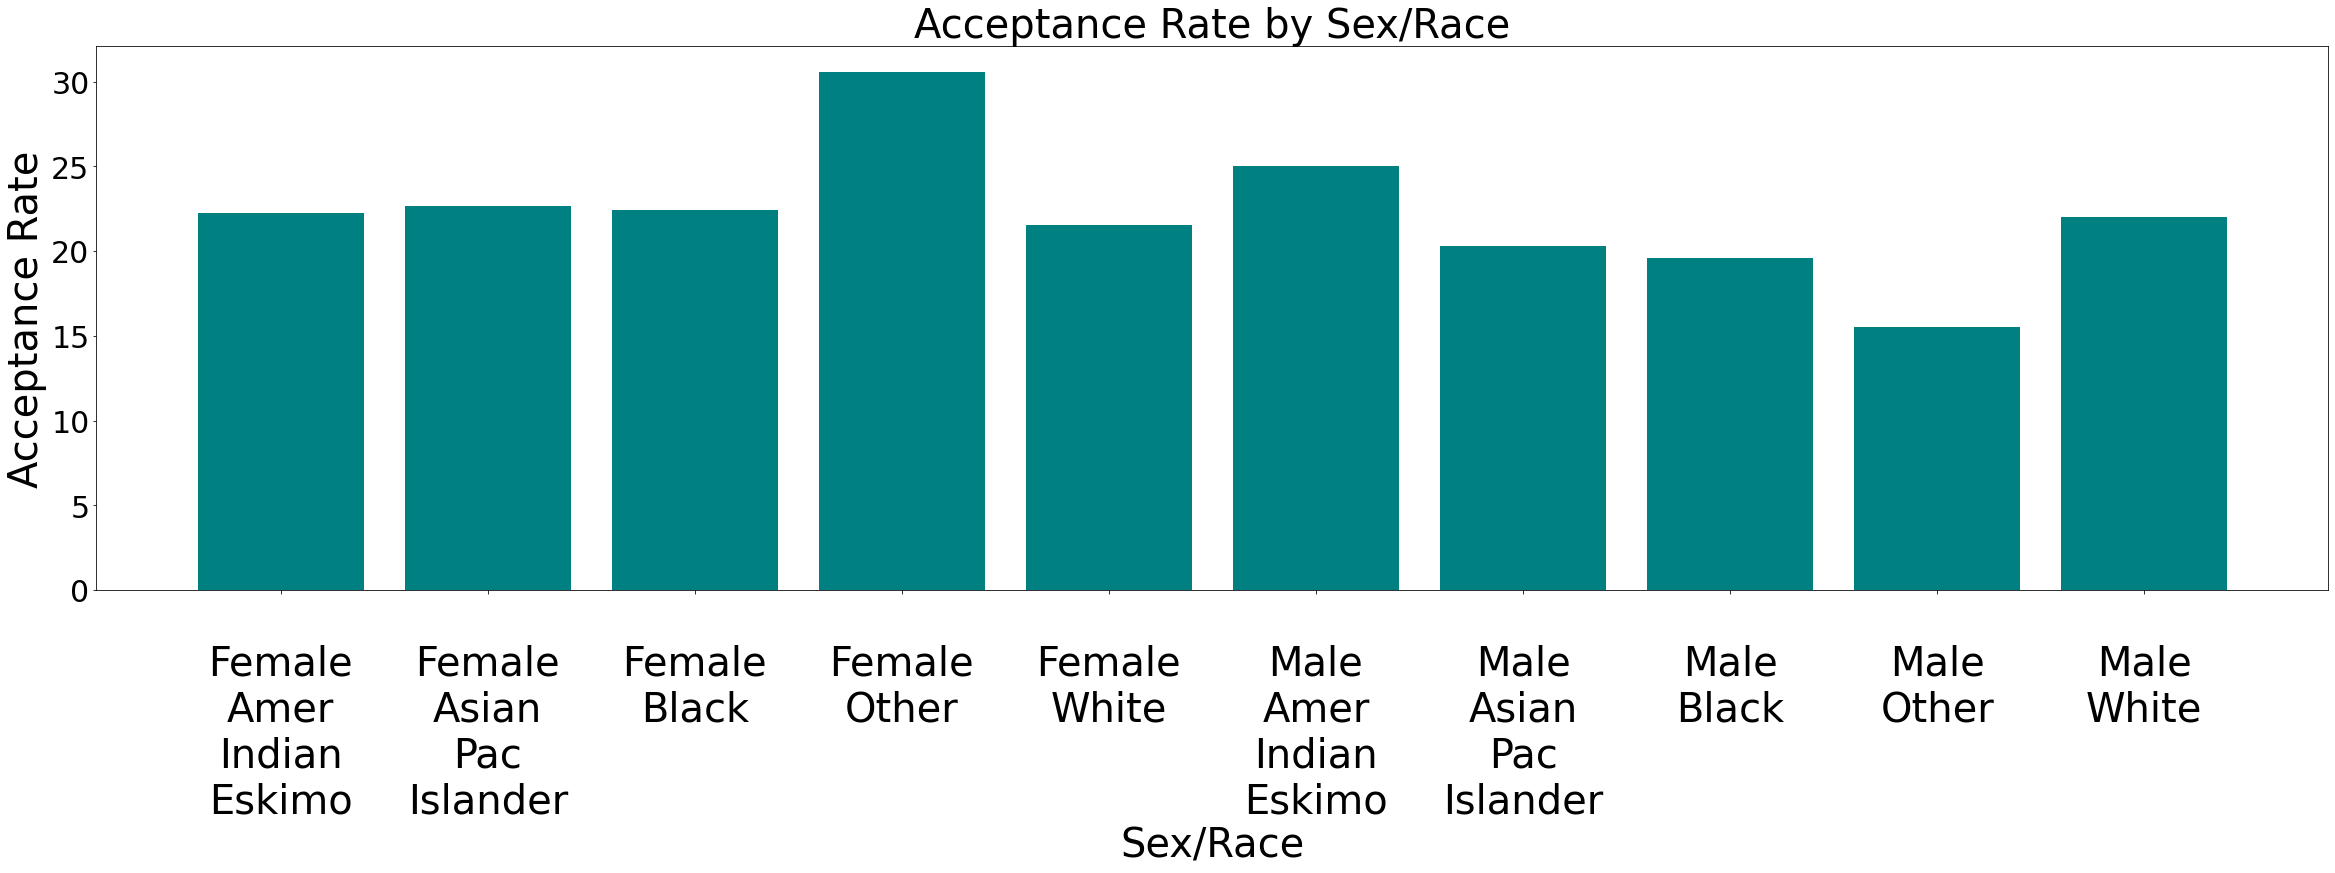

In [16]:
#Runs the model 10 times to get average
avgFairness = 0
avgAcc = 0
xTrain,xTest,yTrain,yTest = splitData(encoded)
for i in range(0,10):
    
    results,model,accuracy = biasModel(xTrain,xTest,yTrain,yTest,encoded)
    checkOverfit(xTrain,xTest,yTrain,yTest,model)
    fairness = evaluateFairness(results) 
    avgFairness += fairness
    avgAcc += accuracy
    print("Accuracy",accuracy)
    print("Fairness",fairness)
    print("\n")
    
avgFairness /= 10
avgAcc /= 10
print("Average Accuracy:",avgAcc,"Average Fairness",avgFairness)
barChart(results)


In [17]:
#Second sampling method
def resampleData(data):
    #For sex-race, going to pick 70% for training data, 30% for test
    possibleValues = data['Age'].unique()
    indexs = []
    #For each unique value
    for value in possibleValues:
        columns = data.loc[data['Age'] == value]
        #Get a sample of the entries at that unique value
        valueIndexs = columns.sample(frac = 0.7).index.values
        #Add the indexs
        indexs.extend(valueIndexs)
    #Shuffle them
    random.shuffle(indexs)
    #Get the training and testing data from the indexs
    train = data.iloc[indexs]
    test = data.drop(indexs)
    yTrain = train['Result']
    yTest = test['Result']
    xTrain = train.drop(['Result'],axis=1)
    xTest = test.drop(['Result'],axis=1)

    return xTrain,xTest,yTrain,yTest

Test 0.807092418716536 Train 0.9671133574967579
Accuracy 0.807092418716536
Fairness 0.9944887169153398


Test 0.8074028090323582 Train 0.9670801050776444
Accuracy 0.8074028090323582
Fairness 1.0017242855913608


Test 0.8074804066113137 Train 0.9671133574967579
Accuracy 0.8074804066113137
Fairness 0.9995683977571851


Test 0.8064716380848918 Train 0.9671133574967579
Accuracy 0.8064716380848918
Fairness 0.9982177764713935


Test 0.8060060526111585 Train 0.9671466099158714
Accuracy 0.8060060526111585
Fairness 0.998689217365648


Test 0.8083339799798246 Train 0.9671133574967579
Accuracy 0.8083339799798246
Fairness 1.000103540048411


Test 0.8078683945060914 Train 0.9671466099158714
Accuracy 0.8078683945060914
Fairness 1.0001298800704923


Test 0.8056180647163809 Train 0.9671466099158714
Accuracy 0.8056180647163809
Fairness 0.9926241871373128


Test 0.8084891751377357 Train 0.9670801050776444
Accuracy 0.8084891751377357
Fairness 0.996983536626736


Test 0.8063940405059362 Train 0.9671466099

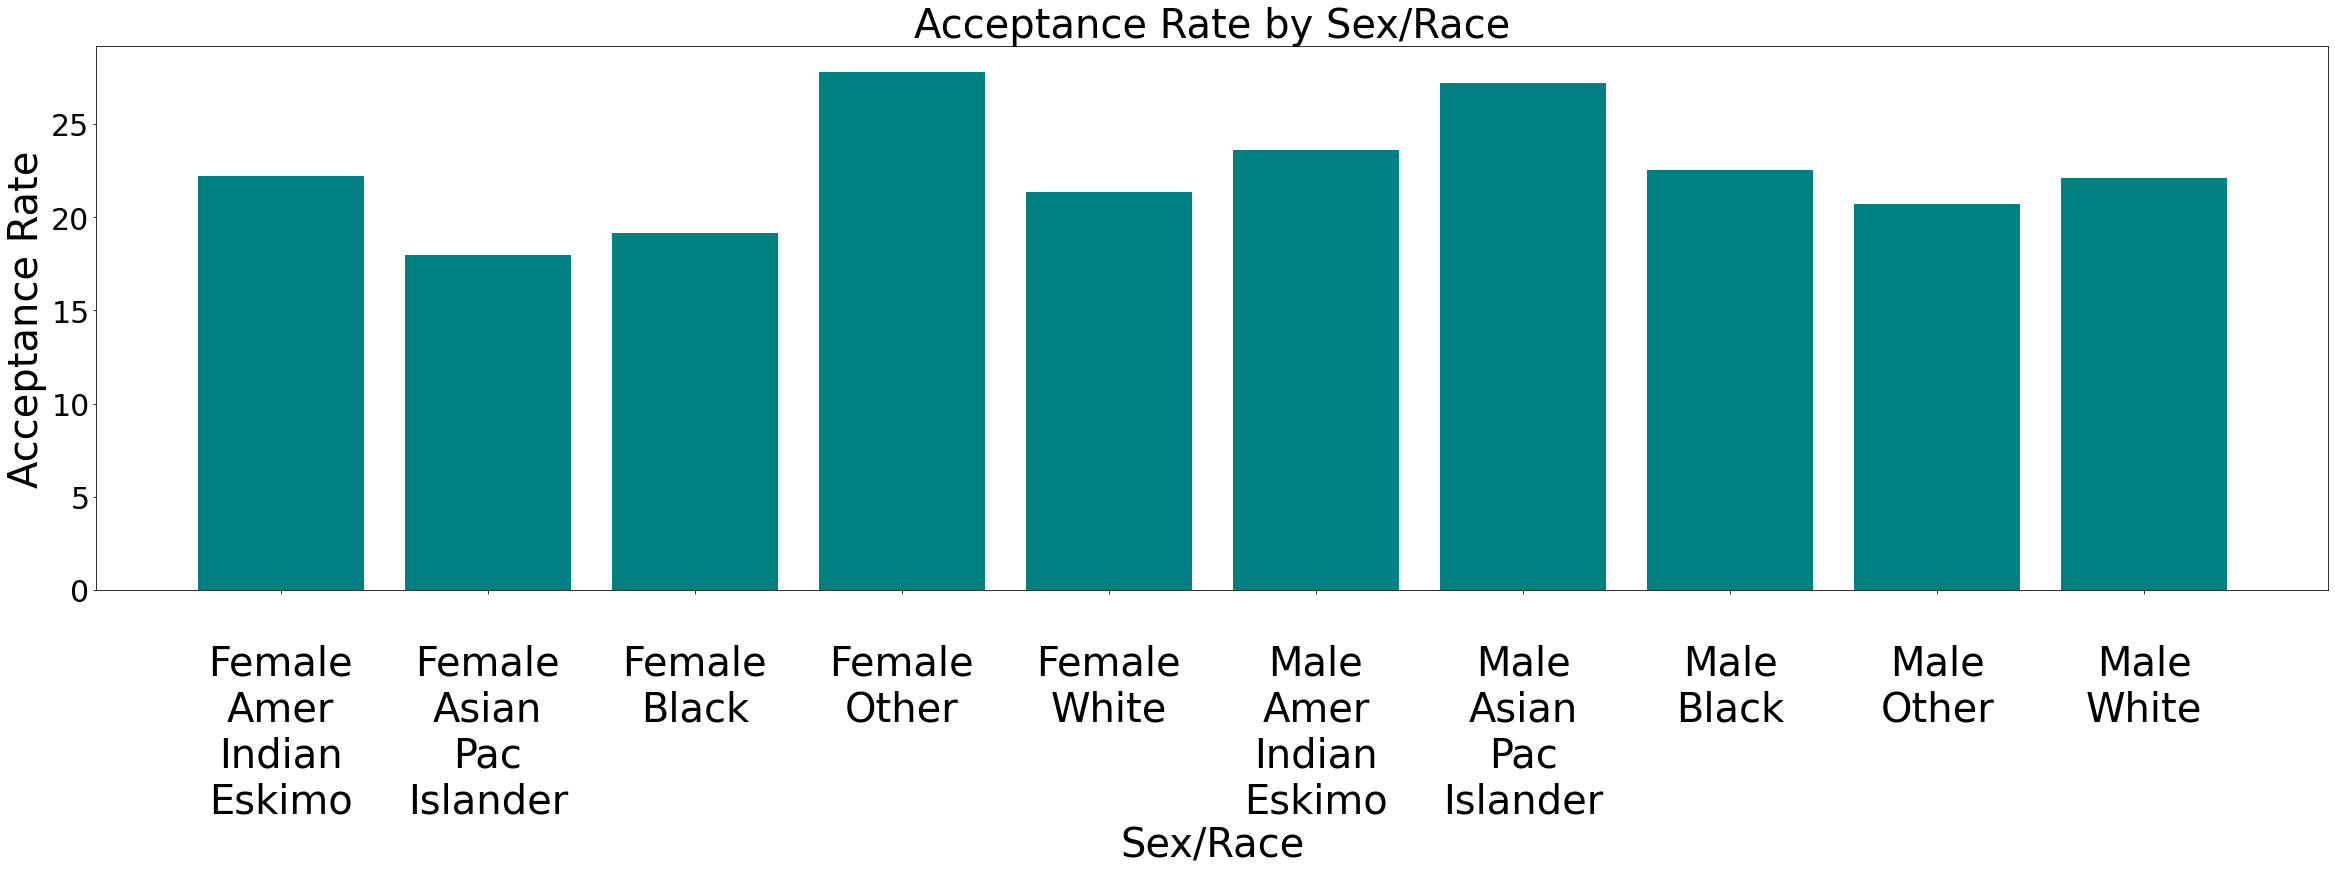

In [18]:
#Get the resampled data
xTrain2,xTest2,yTrain2,yTest2 = resampleData(encoded)
#Run 10 times to get average
for i in range(0,10):
    results,model,accuracy = biasModel(xTrain2,xTest2,yTrain2,yTest2,encoded)
    checkOverfit(xTrain2,xTest2,yTrain2,yTest2,model)
    fairness = evaluateFairness(results) 
    avgFairness += fairness
    avgAcc += accuracy
    print("Accuracy",accuracy)
    print("Fairness",fairness)
    print("\n")
    
avgFairness /= 10
avgAcc /= 10
print("Average Accuracy:",avgAcc,"Average Fairness",avgFairness)
barChart(results)

In [19]:
#Function to remove bias
def removeDisImpact(sensitiveAttribute,data):
    uniqueSensAtts = data[sensitiveAttribute].unique()
    #For each column
    for column in data.columns:
        #If nott the sex_race or the result column
        if column != sensitiveAttribute and column != "Result":
            #Repair the column
            newValues = repairColumn(data,data[column],sensitiveAttribute,uniqueSensAtts)
            data[column] = newValues
    #Sensitive attribute no longer needed
    data = data.drop(sensitiveAttribute,axis = 1)
    return data

In [20]:
#Function to repair column
def repairColumn(data,column,sensAttr,uniqueSensAtts):
    #Get the median of means and median of standard deviation
    medianMean,medianSTDs = getMeans(data,column,sensAttr,uniqueSensAtts)
    newValues = []
    for value in uniqueSensAtts:
        oldMedian = getMedian(data,column,sensAttr,value)
        columnValues = column.loc[data[sensAttr] == value].values
        #For each value at that unique value
        for colVal in columnValues:
            #Get the percentile
            percentile = stats.percentileofscore(columnValues, colVal)
        
            percentile /= 100
            #Removes rounding errors 
            percentile = max(percentile,0.01)
            percentile = min(percentile,0.99)
            #Calculate the new score so that its the same percentile of the new mean and standard deviation
            newScore = NormalDist(mu=medianMean, sigma=medianSTDs).inv_cdf(percentile)
            newValues.append(int(round(newScore,0)))
    return newValues
    

In [21]:
#Get the media of that column
def getMedian(data,column,sensAttr,value):
    values = column.loc[data[sensAttr] == value].values
    #Get the values, sort them and pick the middle
    values.sort()
    median = int((values[len(values)//2]).round()) 
    return median

In [22]:
#Get the means of each unique value so the median of it can be picked
def getMeans(data,column,sensAttr,uniqueSensAtts):
    means = []
    stds = []
    #For each unique value
    for value in uniqueSensAtts:
        #Get the total
        total = sum(column.loc[data[sensAttr] == value].values)
        #Divide the total by the length
        mean = total/len(column.loc[data[sensAttr] == value].index)
        #Append it 
        means.append(mean)
        #Get the standard deviation and add it to the list
        std = np.std(column.loc[data[sensAttr] == value].values)
        stds.append(std)
    #Sort and pick the medians
    means.sort()
    stds.sort()
    medianMean = int((means[len(means)//2]).round())
    stdsMean = max(int((stds[len(stds)//2]).round()),0.01)
    return medianMean,stdsMean    

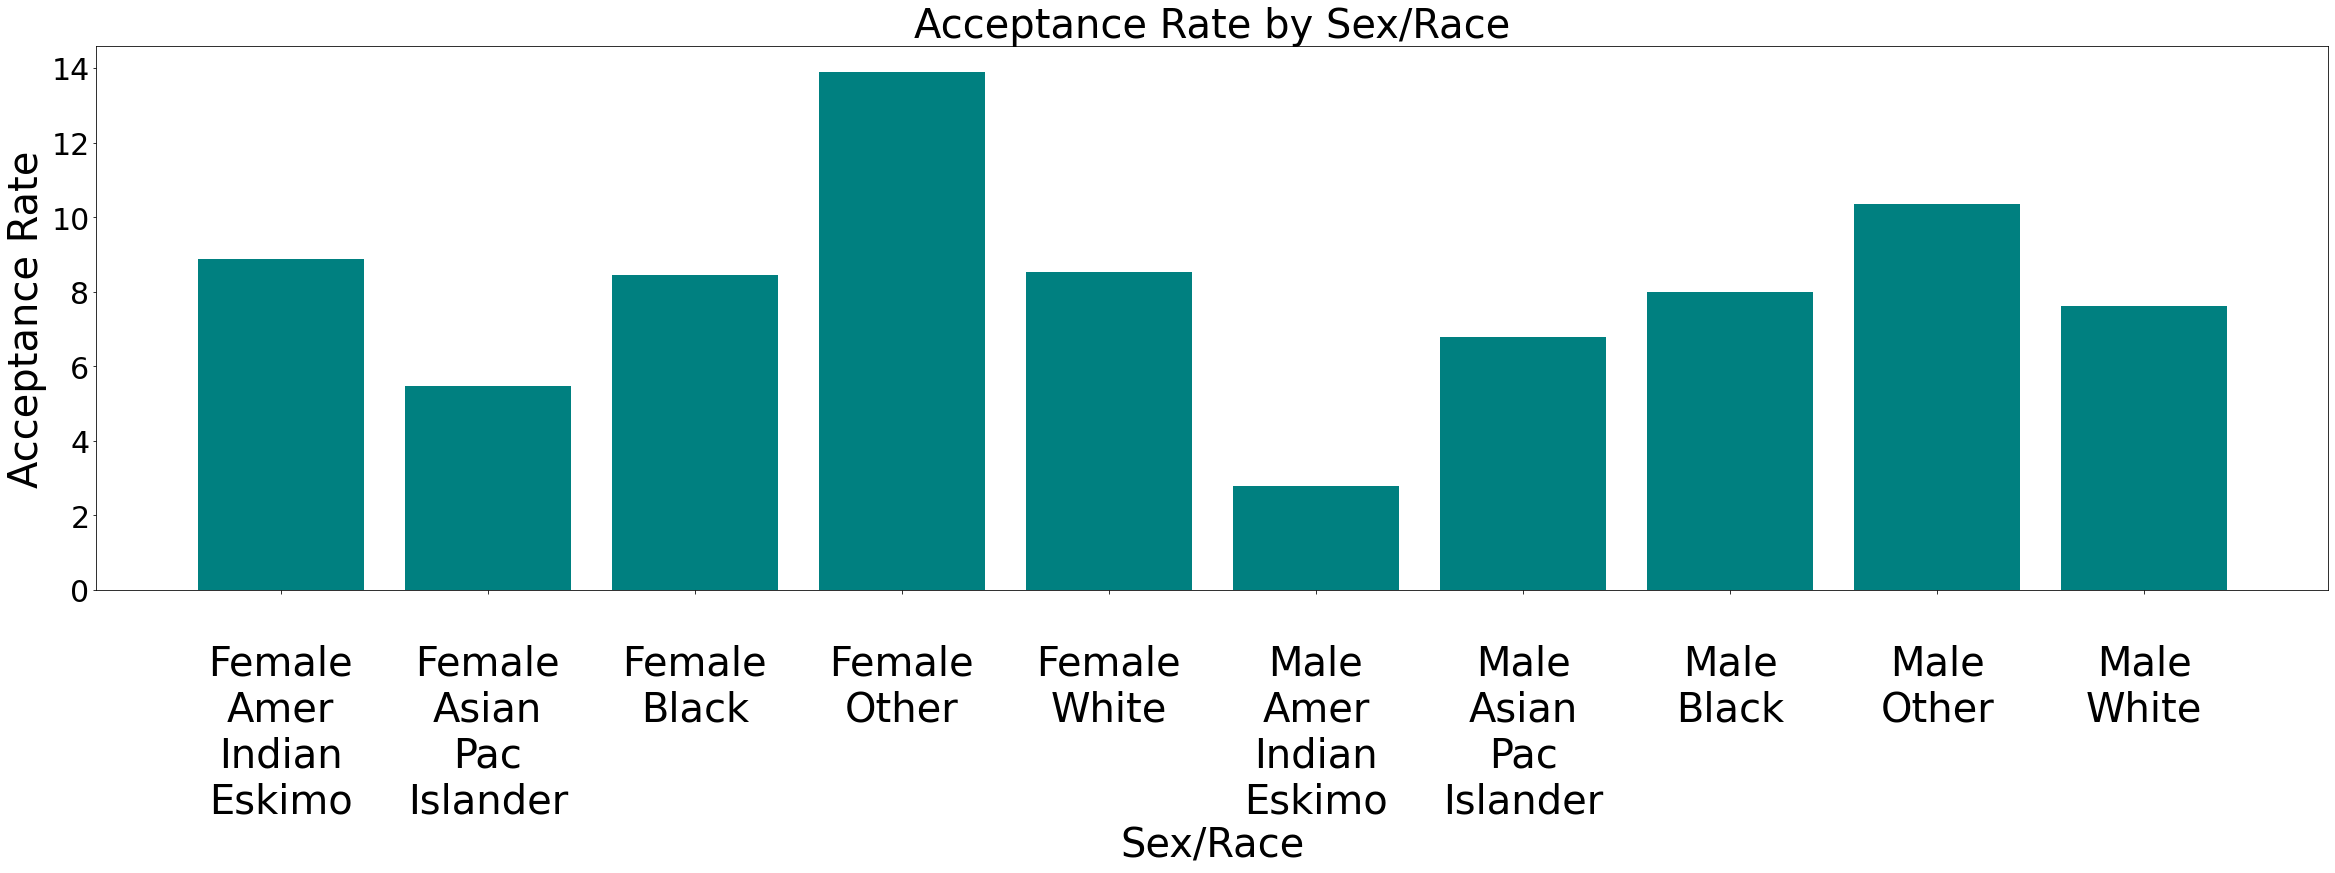

In [24]:
#Resample the data
xTrain,xTest,yTrain,yTest = resampleData(encoded)
#Remove any bias
xTrain = removeDisImpact("Sex_Race",xTrain)
xTest = removeDisImpact("Sex_Race",xTest)
#Rerun the model
fixedResults,model,accuracy = biasModel(xTrain,xTest,yTrain,yTest,encoded)
#Evaluate the fairness of these results
evaluateFairness(fixedResults)   
print("\n")
barChart(fixedResults)